In [2]:
import pandas as pd
import utils.DataEngine as de
import matplotlib.pyplot as plt
import sys
sys.path.append('..')
import re
import statsmodels.api as sm
from statsmodels.tsa.ar_model import AutoReg
from sklearn.linear_model import Ridge, LinearRegression, Lasso
from scipy.stats import norm
import scipy.stats as st
import numpy as np
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, AdaBoostRegressor, RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from ipywidgets import interact
from scipy import interpolate
import statsmodels.formula.api as smf
from sklearn.preprocessing import PolynomialFeatures

In [3]:
data = de.DataEngine('data2024')
round_5_df = data.data['round_5']['trade_df']

In [4]:
round_5_df.buyer.unique()

array(['Vinnie', 'Remy', 'Ruby', 'Rhianna', 'Valentina', 'Vladimir',
       'Adam', 'Amelia', 'Raj'], dtype=object)

In [5]:
round_5_df.seller.unique()

array(['Ruby', 'Valentina', 'Remy', 'Vinnie', 'Vladimir', 'Rhianna',
       'Amelia', 'Adam', 'Raj'], dtype=object)

In [6]:
round_5_df[round_5_df.buyer == 'Valentina'].symbol.unique()

array(['STARFRUIT', 'AMETHYSTS', 'COCONUT_COUPON'], dtype=object)

Raj only trades coconuts

Rhianna buy signal roses

In [7]:
round_2_data = data.data['round_2']['price_df']
round_3_data = data.data['round_3']['price_df']
round_4_data = data.data['round_4']['price_df']

straw_rd_3 = round_3_data[round_3_data['product'] == 'STRAWBERRIES']
roses_rd_3 = round_3_data[round_3_data['product'] == 'ROSES']
choco_rd_3 = round_3_data[round_3_data['product'] == 'CHOCOLATE']
coco_rd_4 = round_4_data[round_4_data['product'] == 'COCONUT']
coup_rd_4 = round_4_data[round_4_data['product'] == 'COCONUT_COUPON']
orchids_rd_2 = round_2_data

In [8]:
roses_trades = round_5_df[(round_5_df.symbol == 'ROSES')]
straw_trades = round_5_df[(round_5_df.symbol == 'STRAWBERRIES')]
choco_trades = round_5_df[(round_5_df.symbol == 'CHOCOLATE')]
coco_trades = round_5_df[(round_5_df.symbol == 'COCONUT')]
coup_trades = round_5_df[(round_5_df.symbol == 'COCONUT_COUPON')]

In [9]:
roses_merged_df = pd.merge(roses_trades, roses_rd_3, on=['timestamp', 'day'], how='outer')
straw_merged_df = pd.merge(straw_trades, straw_rd_3, on=['timestamp', 'day'], how='outer')
choco_merged_df = pd.merge(choco_trades, choco_rd_3, on=['timestamp', 'day'], how='outer')
coco_merged_df = pd.merge(coco_trades, coco_rd_4, on=['timestamp', 'day'], how='outer')
coup_merged_df = pd.merge(coup_trades, coup_rd_4, on=['timestamp', 'day'], how='outer')

In [10]:
roses_merged_df['buyer'].unique()

array(['Remy', nan, 'Vinnie', 'Rhianna', 'Vladimir'], dtype=object)

In [11]:
roses_merged_df[roses_merged_df['buyer'] == 'Rhianna']

,timestamp,buyer,seller,symbol,currency,price,quantity,day,product,bid_price_1,...,bid_price_3,bid_volume_3,ask_price_1,ask_volume_1,ask_price_2,ask_volume_2,ask_price_3,ask_volume_3,mid_price,profit_and_loss
9148,2914000,Rhianna,Vinnie,ROSES,SEASHELLS,14381.0,3.0,0,ROSES,14380,...,NaN,NaN,14381,28,14382.0,43.0,NaN,NaN,14380.5,0.0
19364,3934400,Rhianna,Vinnie,ROSES,SEASHELLS,14394.0,3.0,1,ROSES,14392,...,NaN,NaN,14394,53,NaN,NaN,NaN,NaN,14393.0,0.0
26182,4615400,Rhianna,Vinnie,ROSES,SEASHELLS,14219.0,3.0,2,ROSES,14217,...,NaN,NaN,14219,67,NaN,NaN,NaN,NaN,14218.0,0.0


In [12]:
roses_merged_df.mid_price.min()

14218.0

In [13]:
roses_merged_df[roses_merged_df['seller'] == 'Rhianna']

,timestamp,buyer,seller,symbol,currency,price,quantity,day,product,bid_price_1,...,bid_price_3,bid_volume_3,ask_price_1,ask_volume_1,ask_price_2,ask_volume_2,ask_price_3,ask_volume_3,mid_price,profit_and_loss
2,2000200,Vinnie,Rhianna,ROSES,SEASHELLS,15000.0,3.0,0,ROSES,15000,...,NaN,NaN,15001,21,15002.0,40.0,NaN,NaN,15000.5,0.0
12897,3288600,Vinnie,Rhianna,ROSES,SEASHELLS,14634.0,3.0,1,ROSES,14634,...,NaN,NaN,14636,71,NaN,NaN,NaN,NaN,14635.0,0.0
21388,4136700,Vinnie,Rhianna,ROSES,SEASHELLS,14488.0,3.0,2,ROSES,14488,...,NaN,NaN,14489,64,NaN,NaN,NaN,NaN,14488.5,0.0


In [14]:
straw_merged_df[straw_merged_df.quantity == 12]

,timestamp,buyer,seller,symbol,currency,price,quantity,day,product,bid_price_1,...,bid_price_3,bid_volume_3,ask_price_1,ask_volume_1,ask_price_2,ask_volume_2,ask_price_3,ask_volume_3,mid_price,profit_and_loss
952,2095100,Vinnie,Vladimir,STRAWBERRIES,SEASHELLS,3990.0,12.0,0,STRAWBERRIES,3990,...,NaN,NaN,3991,76,3992.0,100.0,NaN,NaN,3990.5,0.0
1084,2108300,Vinnie,Vladimir,STRAWBERRIES,SEASHELLS,3999.0,12.0,0,STRAWBERRIES,3999,...,NaN,NaN,4001,245,NaN,NaN,NaN,NaN,4000.0,0.0
1322,2132000,Vinnie,Vladimir,STRAWBERRIES,SEASHELLS,3997.0,12.0,0,STRAWBERRIES,3997,...,NaN,NaN,3998,54,3999.0,171.0,NaN,NaN,3997.5,0.0
1606,2160300,Vinnie,Vladimir,STRAWBERRIES,SEASHELLS,3993.0,12.0,0,STRAWBERRIES,3993,...,NaN,NaN,3994,99,3995.0,124.0,NaN,NaN,3993.5,0.0
2099,2209200,Vinnie,Vladimir,STRAWBERRIES,SEASHELLS,4004.0,12.0,0,STRAWBERRIES,4004,...,NaN,NaN,4005,233,NaN,NaN,NaN,NaN,4004.5,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29056,4894900,Vinnie,Vladimir,STRAWBERRIES,SEASHELLS,3996.0,12.0,2,STRAWBERRIES,3996,...,NaN,NaN,3998,168,NaN,NaN,NaN,NaN,3997.0,0.0
29721,4961400,Vinnie,Vladimir,STRAWBERRIES,SEASHELLS,3986.0,12.0,2,STRAWBERRIES,3986,...,NaN,NaN,3987,221,NaN,NaN,NaN,NaN,3986.5,0.0
29806,4969800,Vinnie,Vladimir,STRAWBERRIES,SEASHELLS,3985.0,12.0,2,STRAWBERRIES,3985,...,NaN,NaN,3987,208,NaN,NaN,NaN,NaN,3986.0,0.0
29913,4980400,Vinnie,Vladimir,STRAWBERRIES,SEASHELLS,3984.0,12.0,2,STRAWBERRIES,3984,...,NaN,NaN,3985,71,3986.0,168.0,NaN,NaN,3984.5,0.0


In [15]:
coco_merged_df[coco_merged_df['seller'] == 'Raj']

,timestamp,buyer,seller,symbol,currency,price,quantity,day,product,bid_price_1,...,bid_price_3,bid_volume_3,ask_price_1,ask_volume_1,ask_price_2,ask_volume_2,ask_price_3,ask_volume_3,mid_price,profit_and_loss
125,3012500,Vinnie,Raj,COCONUT,SEASHELLS,10003.0,10.0,1,COCONUT,10003.0,...,NaN,NaN,10005,104,10006.0,69.0,NaN,NaN,10004.0,0.0
202,3020100,Vinnie,Raj,COCONUT,SEASHELLS,9990.0,10.0,1,COCONUT,9990.0,...,NaN,NaN,9991,111,9992.0,46.0,NaN,NaN,9990.5,0.0
209,3020800,Vinnie,Raj,COCONUT,SEASHELLS,9993.0,10.0,1,COCONUT,9993.0,...,NaN,NaN,9994,137,9995.0,63.0,NaN,NaN,9993.5,0.0
465,3046400,Vinnie,Raj,COCONUT,SEASHELLS,9969.0,8.0,1,COCONUT,9969.0,...,NaN,NaN,9970,142,9971.0,60.0,NaN,NaN,9969.5,0.0
542,3054100,Vinnie,Raj,COCONUT,SEASHELLS,9975.0,6.0,1,COCONUT,9975.0,...,NaN,NaN,9977,103,9978.0,41.0,NaN,NaN,9976.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29528,5948700,Vinnie,Raj,COCONUT,SEASHELLS,9887.0,6.0,3,COCONUT,9887.0,...,NaN,NaN,9889,195,NaN,NaN,NaN,NaN,9888.0,0.0
29675,5963400,Vinnie,Raj,COCONUT,SEASHELLS,9897.0,9.0,3,COCONUT,9897.0,...,NaN,NaN,9899,193,NaN,NaN,NaN,NaN,9898.0,0.0
29904,5986200,Vinnie,Raj,COCONUT,SEASHELLS,9878.0,9.0,3,COCONUT,9878.0,...,NaN,NaN,9879,120,9880.0,43.0,NaN,NaN,9878.5,0.0
29963,5992000,Vinnie,Raj,COCONUT,SEASHELLS,9887.0,9.0,3,COCONUT,9887.0,...,NaN,NaN,9888,100,9889.0,68.0,NaN,NaN,9887.5,0.0


In [16]:
coup_merged_df.iloc[202:].head(20)

,timestamp,buyer,seller,symbol,currency,price,quantity,day,product,bid_price_1,...,bid_price_3,bid_volume_3,ask_price_1,ask_volume_1,ask_price_2,ask_volume_2,ask_price_3,ask_volume_3,mid_price,profit_and_loss
202,3019600,NaN,NaN,NaN,NaN,NaN,NaN,1,COCONUT_COUPON,633.0,...,NaN,NaN,634,41,NaN,NaN,NaN,NaN,633.5,0.0
203,3019700,NaN,NaN,NaN,NaN,NaN,NaN,1,COCONUT_COUPON,633.0,...,NaN,NaN,634,27,NaN,NaN,NaN,NaN,633.5,0.0
204,3019800,NaN,NaN,NaN,NaN,NaN,NaN,1,COCONUT_COUPON,633.0,...,NaN,NaN,634,41,NaN,NaN,NaN,NaN,633.5,0.0
205,3019900,NaN,NaN,NaN,NaN,NaN,NaN,1,COCONUT_COUPON,632.0,...,NaN,NaN,633,44,NaN,NaN,NaN,NaN,632.5,0.0
206,3020000,NaN,NaN,NaN,NaN,NaN,NaN,1,COCONUT_COUPON,631.0,...,NaN,NaN,632,30,NaN,NaN,NaN,NaN,631.5,0.0
207,3020100,NaN,NaN,NaN,NaN,NaN,NaN,1,COCONUT_COUPON,632.0,...,NaN,NaN,633,31,NaN,NaN,NaN,NaN,632.5,0.0
208,3020200,NaN,NaN,NaN,NaN,NaN,NaN,1,COCONUT_COUPON,632.0,...,NaN,NaN,633,34,NaN,NaN,NaN,NaN,632.5,0.0
209,3020300,NaN,NaN,NaN,NaN,NaN,NaN,1,COCONUT_COUPON,632.0,...,NaN,NaN,633,44,NaN,NaN,NaN,NaN,632.5,0.0
210,3020400,NaN,NaN,NaN,NaN,NaN,NaN,1,COCONUT_COUPON,632.0,...,NaN,NaN,633,46,NaN,NaN,NaN,NaN,632.5,0.0
211,3020500,NaN,NaN,NaN,NaN,NaN,NaN,1,COCONUT_COUPON,633.0,...,NaN,NaN,634,40,NaN,NaN,NaN,NaN,633.5,0.0


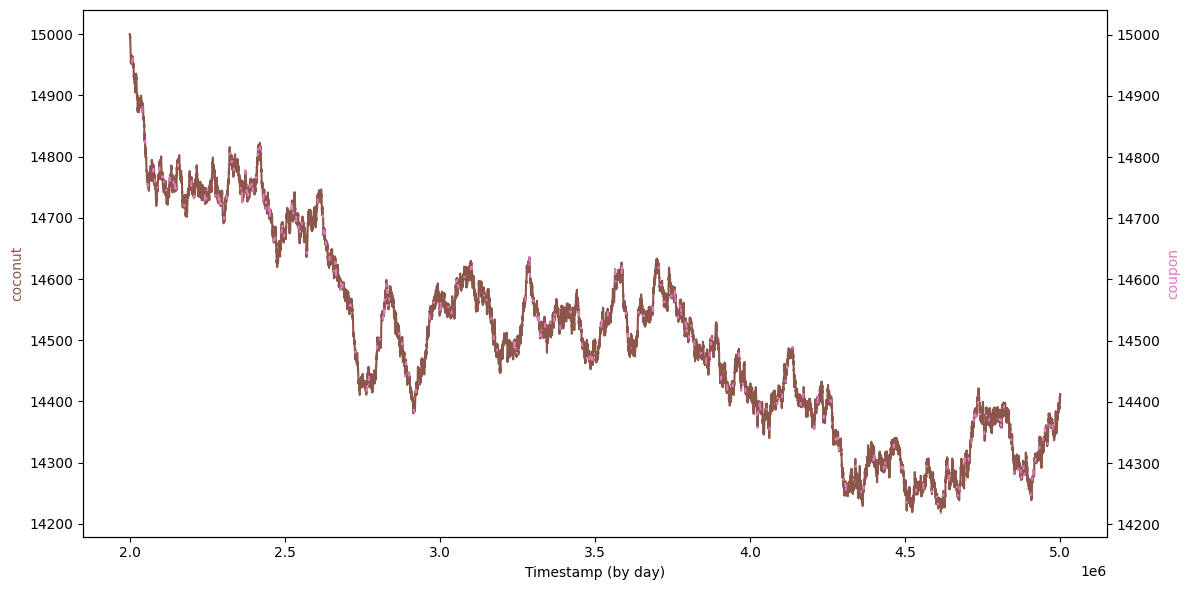

In [17]:
fig, ax1 = plt.subplots(figsize=(12, 6))

shift = 0

color = 'tab:brown'
ax1.set_xlabel('Timestamp (by day)')
ax1.set_ylabel('coconut', color=color)
ax1.plot(roses_merged_df.timestamp.iloc[shift:], roses_merged_df.mid_price.iloc[shift:], color=color, zorder=1)

ax2 = ax1.twinx()
color = 'tab:pink'
ax2.set_xlabel('Timestamp (by day)')
ax2.set_ylabel('coupon', color=color)
ax2.plot(roses_merged_df.timestamp.iloc[shift:], roses_merged_df.price, color=color, zorder=1)

fig.tight_layout()
plt.show()

In [18]:
round_5_df['symbol'].unique()

array(['AMETHYSTS', 'STARFRUIT', 'ROSES', 'CHOCOLATE', 'STRAWBERRIES',
       'GIFT_BASKET', 'COCONUT_COUPON', 'COCONUT'], dtype=object)

In [19]:
rd4_data = pd.read_csv("logs/round4_results.csv")

In [20]:
coconut = rd4_data[rd4_data['product'] == 'COCONUT'].copy()
coconut_coupon = rd4_data[rd4_data['product'] == 'COCONUT_COUPON'].copy()
gift_basket = rd4_data[rd4_data['product'] == 'GIFT_BASKET'].copy()
orchids = rd4_data[rd4_data['product'] == 'ORCHIDS'].copy()
strawberries = rd4_data[rd4_data['product'] == 'STRAWBERRIES'].copy()
chocolate = rd4_data[rd4_data['product'] == 'CHOCOLATE'].copy()
roses = rd4_data[rd4_data['product'] == 'ROSES'].copy().copy()

In [21]:
coconut.reset_index(drop=True, inplace=True)
coconut_coupon.reset_index(drop=True, inplace=True)
gift_basket.reset_index(drop=True, inplace=True)
orchids.reset_index(drop=True, inplace=True)
strawberries.reset_index(drop=True, inplace=True)
chocolate.reset_index(drop=True, inplace=True)
roses.reset_index(drop=True, inplace=True)

<Axes: >

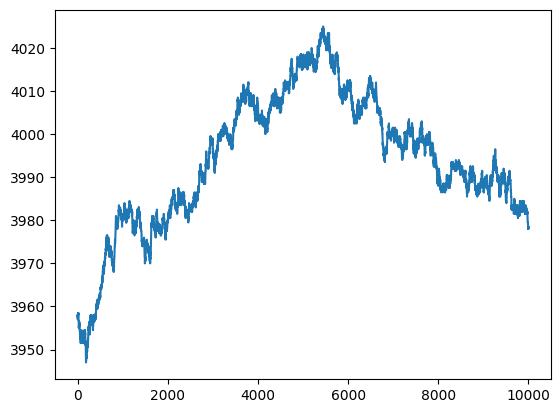

In [22]:
(strawberries.mid_price).plot()

<Axes: >

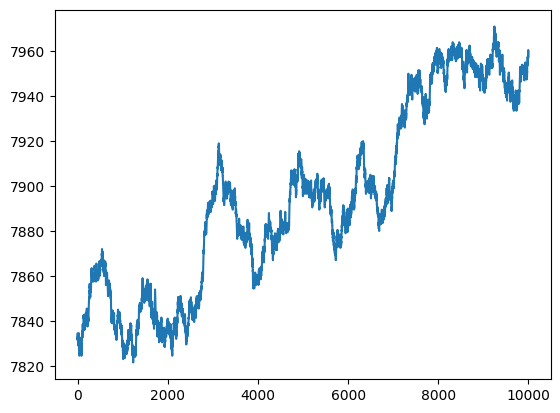

In [23]:
(chocolate.mid_price).plot()

<Axes: >

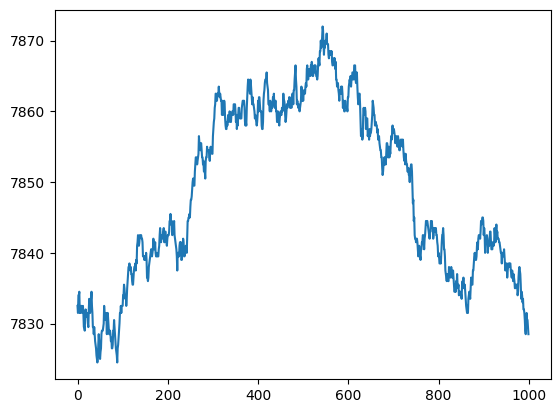

In [24]:
chocolate.iloc[:1000].mid_price.plot()

In [25]:
chocolate['20_ma'] = chocolate['mid_price'].rolling(window=20).mean()

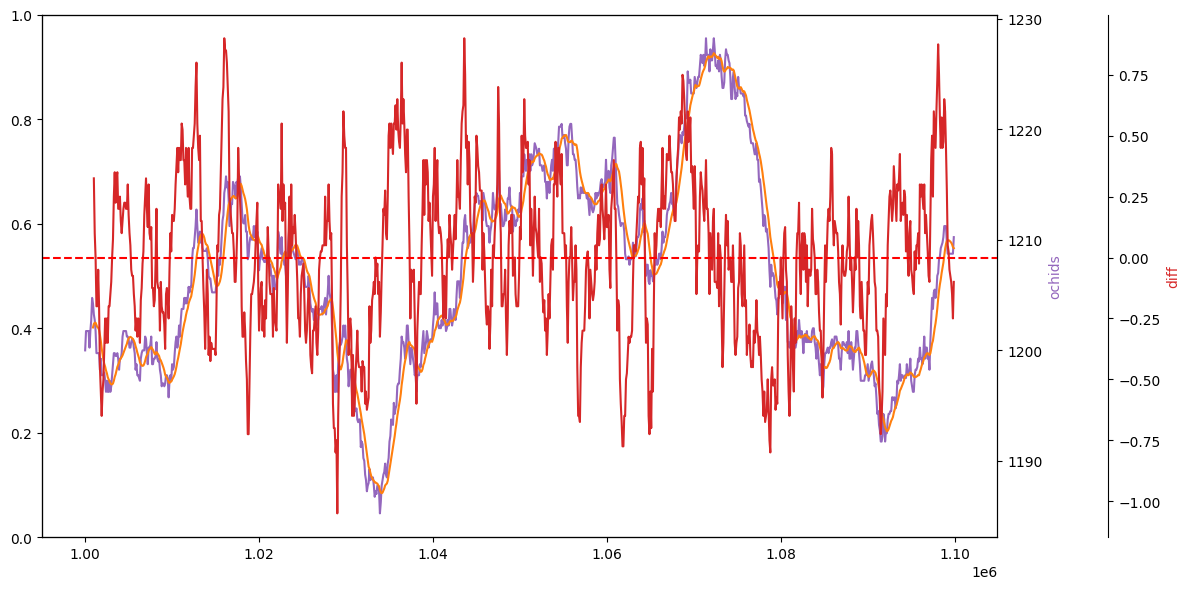

In [26]:
orchids_rd_2['20_day_ma'] = orchids_rd_2['ORCHIDS'].rolling(window=10).mean()

fig, ax1 = plt.subplots(figsize=(12, 6))

shift = 0
end = 1000

ax3 = ax1.twinx()
color = 'tab:purple'
ax3.set_xlabel('Timestamp (by day)')
ax3.set_ylabel('ochids', color=color)
ax3.plot(orchids_rd_2.timestamp.iloc[shift:end], orchids_rd_2.ORCHIDS.iloc[shift:end], color=color, zorder=1)

ax4 = ax1.twinx()
color = 'tab:red'
ax4.spines['right'].set_position(('outward', 80))
ax4.set_xlabel('Timestamp (by day)')
ax4.set_ylabel('diff', color=color)
ax4.plot(orchids_rd_2.timestamp.iloc[shift:end], orchids_rd_2['20_day_ma'].diff()[shift:end], color=color, zorder=1)

ax3.plot(orchids_rd_2.timestamp.iloc[shift:end], orchids_rd_2['20_day_ma'][shift:end], color="tab:orange", label="50-Day MA", zorder=2)

#ax4.axhline(0.05, color='green', linestyle='--')
ax4.axhline(0, color='red', linestyle='--')
#ax4.axhline(-0.05, color='green', linestyle='--')

fig.tight_layout()
plt.show()

In [27]:
results_rd4 = pd.read_csv('logs/round4_results.csv')
coco_results_rd4 = results_rd4[results_rd4['product'] == 'COCONUT']
coco_results_rd4.reset_index(drop=True, inplace=True)

coup_results_rd4 = results_rd4[results_rd4['product'] == 'COCONUT_COUPON']
coup_results_rd4.reset_index(drop=True, inplace=True)

C:\Users\giova\AppData\Local\Temp\ipykernel_6168\3920804458.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  coco_results_rd4['20_day_ma'] = coco_results_rd4['mid_price'].rolling(window=50).mean()


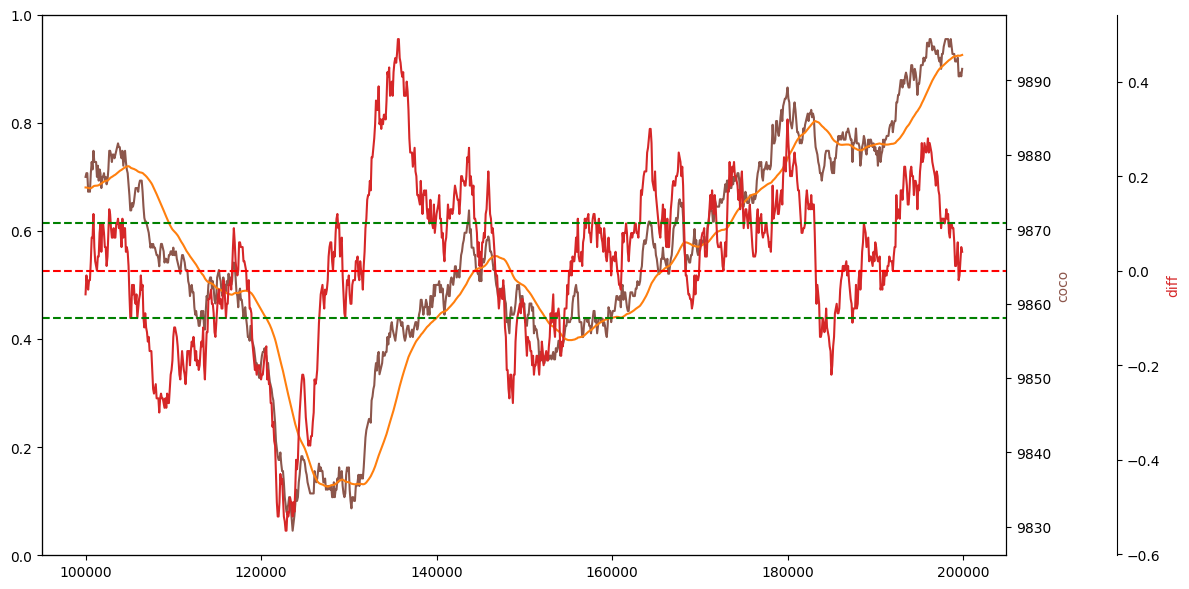

In [64]:
coco_results_rd4['20_day_ma'] = coco_results_rd4['mid_price'].rolling(window=50).mean()

fig, ax1 = plt.subplots(figsize=(12, 6))

shift = 1000
end = 2000

ax3 = ax1.twinx()
color = 'tab:brown'
ax3.set_xlabel('Timestamp (by day)')
ax3.set_ylabel('coco', color=color)
ax3.plot(coco_results_rd4.timestamp.iloc[shift:end], coco_results_rd4.mid_price.iloc[shift:end], color=color, zorder=1)

ax4 = ax1.twinx()
color = 'tab:red'
ax4.spines['right'].set_position(('outward', 80))
ax4.set_xlabel('Timestamp (by day)')
ax4.set_ylabel('diff', color=color)
ax4.plot(coco_results_rd4.timestamp.iloc[shift:end], coco_results_rd4['20_day_ma'].diff()[shift:end], color=color, zorder=1)

ax3.plot(coco_results_rd4.timestamp.iloc[shift:end], coco_results_rd4['20_day_ma'][shift:end], color="tab:orange", label="50-Day MA", zorder=2)

ax4.axhline(0.1, color='green', linestyle='--')
ax4.axhline(0, color='red', linestyle='--')
ax4.axhline(-0.1, color='green', linestyle='--')

fig.tight_layout()
plt.show()

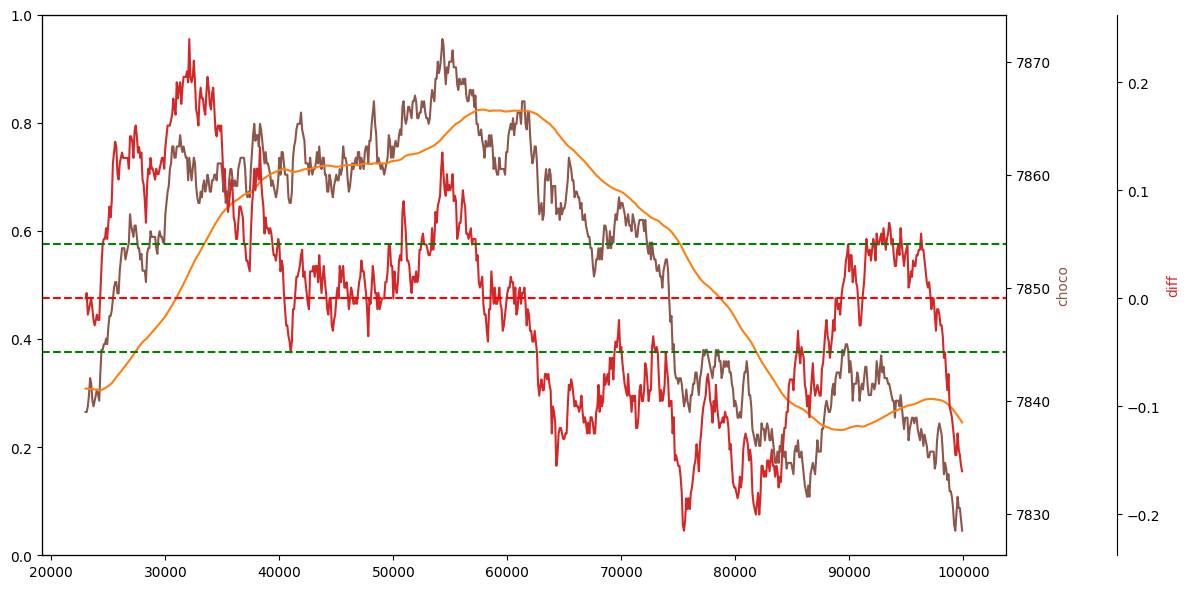

In [46]:
chocolate['20_day_ma'] = chocolate['mid_price'].rolling(window=100).mean()

fig, ax1 = plt.subplots(figsize=(12, 6))

shift = 230
end = 1000

ax3 = ax1.twinx()
color = 'tab:brown'
ax3.set_xlabel('Timestamp (by day)')
ax3.set_ylabel('choco', color=color)
ax3.plot(chocolate.timestamp.iloc[shift:end], chocolate.mid_price.iloc[shift:end], color=color, zorder=1)

ax4 = ax1.twinx()
color = 'tab:red'
ax4.spines['right'].set_position(('outward', 80))
ax4.set_xlabel('Timestamp (by day)')
ax4.set_ylabel('diff', color=color)
ax4.plot(chocolate.timestamp.iloc[shift:end], chocolate['20_day_ma'].diff()[shift:end], color=color, zorder=1)

ax3.plot(chocolate.timestamp.iloc[shift:end], chocolate['20_day_ma'][shift:end], color="tab:orange", label="50-Day MA", zorder=2)

ax4.axhline(0.05, color='green', linestyle='--')
ax4.axhline(0, color='red', linestyle='--')
ax4.axhline(-0.05, color='green', linestyle='--')

fig.tight_layout()
plt.show()

In [58]:
chocolate['20_day_ma'].iloc[100:120]

100    7829.700
101    7829.725
102    7829.725
103    7829.740
104    7829.745
105    7829.770
106    7829.780
107    7829.805
108    7829.805
109    7829.815
110    7829.845
111    7829.890
112    7829.935
113    7830.000
114    7830.085
115    7830.175
116    7830.265
117    7830.330
118    7830.390
119    7830.445
Name: 20_day_ma, dtype: float64

In [56]:
sum(list(chocolate['mid_price'].iloc[:100]))/100

7829.7

C:\Users\giova\AppData\Local\Temp\ipykernel_6168\1808011202.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  coup_results_rd4['20_day_ma'] = coup_results_rd4['mid_price'].rolling(window=100).mean()


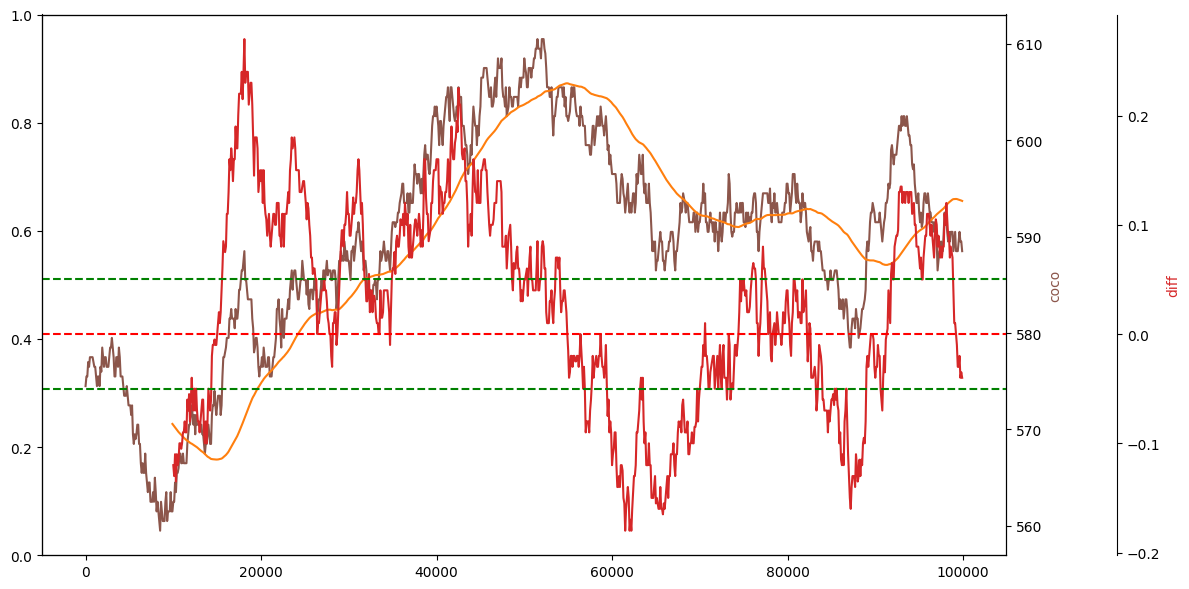

In [30]:
coup_results_rd4['20_day_ma'] = coup_results_rd4['mid_price'].rolling(window=100).mean()

fig, ax1 = plt.subplots(figsize=(12, 6))

shift = 0
end = 1000

ax3 = ax1.twinx()
color = 'tab:brown'
ax3.set_xlabel('Timestamp (by day)')
ax3.set_ylabel('coco', color=color)
ax3.plot(coup_results_rd4.timestamp.iloc[shift:end], coup_results_rd4.mid_price.iloc[shift:end], color=color, zorder=1)

ax4 = ax1.twinx()
color = 'tab:red'
ax4.spines['right'].set_position(('outward', 80))
ax4.set_xlabel('Timestamp (by day)')
ax4.set_ylabel('diff', color=color)
ax4.plot(coup_results_rd4.timestamp.iloc[shift:end], coup_results_rd4['20_day_ma'].diff().iloc[shift:end], color=color, zorder=1)

ax3.plot(coup_results_rd4.timestamp.iloc[shift:end], coup_results_rd4['20_day_ma'].iloc[shift:end], color="tab:orange", label="50-Day MA", zorder=2)

ax4.axhline(0.05, color='green', linestyle='--')
ax4.axhline(0, color='red', linestyle='--')
ax4.axhline(-0.05, color='green', linestyle='--')

fig.tight_layout()
plt.show()

In [31]:
coup_results_rd4['20_day_ma'].diff().std()

0.10782028769464823